In [524]:
from sys import argv
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import sqlite3
import warnings
warnings.simplefilter("ignore")
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [525]:
btc = yf.download('BTC-USD', start = "2010-07-10", end = "2022-11-24")

[*********************100%***********************]  1 of 1 completed


In [526]:
#btc = pd.read_csv('../dataset/Dataframes_clean/df2.csv')

In [527]:
btc = btc.reset_index()

In [528]:
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [529]:
#Divide data into training set and test set
training_set = btc.iloc[:2300, 1:2].values
test_set = btc.iloc[2300:, 1:2].values

In [530]:
# Feature Scaling --> scale the stock prices between (0, 1) to avoid intensive computation. 
# Normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(2240, 60, 1)

In [531]:
X_train.shape

(2240, 60, 1)

In [532]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
70/70 [==============================] - 9s 54ms/step - loss: 0.0067
Epoch 2/50
70/70 [==============================] - 4s 53ms/step - loss: 0.0021
Epoch 3/50
70/70 [==============================] - 4s 53ms/step - loss: 0.0018
Epoch 4/50
70/70 [==============================] - 4s 52ms/step - loss: 0.0018
Epoch 5/50
70/70 [==============================] - 4s 51ms/step - loss: 0.0015
Epoch 6/50
70/70 [==============================] - 4s 51ms/step - loss: 0.0015
Epoch 7/50
70/70 [==============================] - 4s 52ms/step - loss: 0.0012
Epoch 8/50
70/70 [==============================] - 4s 61ms/step - loss: 0.0012
Epoch 9/50
70/70 [==============================] - 4s 61ms/step - loss: 0.0011
Epoch 10/50
70/70 [==============================] - 4s 61ms/step - loss: 9.7134e-04
Epoch 11/50
70/70 [==============================] - 4s 61ms/step - loss: 0.0010
Epoch 12/50
70/70 [==============================] - 4s 63ms/step - loss: 9.5813e-04
Epoch 13/50
70/70 [==========

In [533]:
real_btc_price = test_set

In [534]:
#Concatenate the train and test datasets for prediction, because we use the previous 60 days’ stock prices to predict the next-day price. 
#In another word, we need the 60 days’ price before the 1st date in the test dataset.
dataset_train = btc.iloc[:2300, 1:2]
dataset_test = btc.iloc[2300:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

In [535]:
len(dataset_total)

2990

In [536]:
#Create the input for prediction, index starting from the date 60 days before the first date in the test dataset.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#Reshape to have only 1 column
inputs = inputs.reshape(-1,1)
#Using the scale set by the training set, scale the test inputs.
inputs = sc.transform(inputs)

In [537]:
#Create test data structure
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (690, 60, 1)

(690, 60, 1)


In [538]:
#X_test ready for prediction
predicted_btc_price = model.predict(X_test)

22/22 [==============================] - 4s 37ms/step


In [539]:
#We have predicted the scaled values, so we need to reverse the prediction.
predicted_btc_price = sc.inverse_transform(predicted_btc_price)


In [540]:
real_btc_price[0]

array([32129.40820312])

In [541]:
len(predicted_btc_price)

690

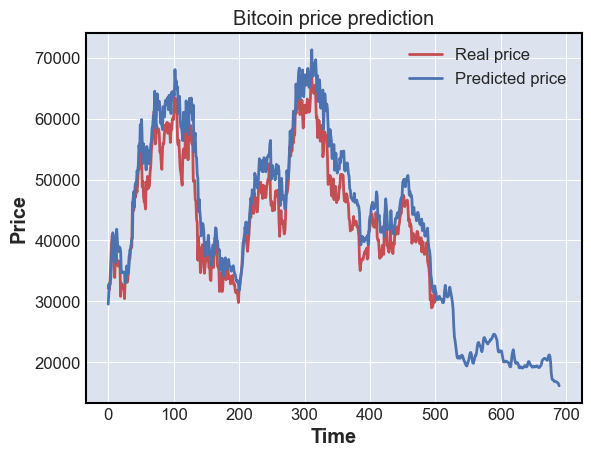

In [548]:
plt.plot(real_btc_price[:500], color = "r", label = 'Real price')
plt.plot(predicted_btc_price, color = "b", label = 'Predicted price')
plt.title('Bitcoin price prediction')
plt.xlabel('Time')
#plt.yscale('log')
plt.ylabel('Price')
plt.legend()
plt.show()

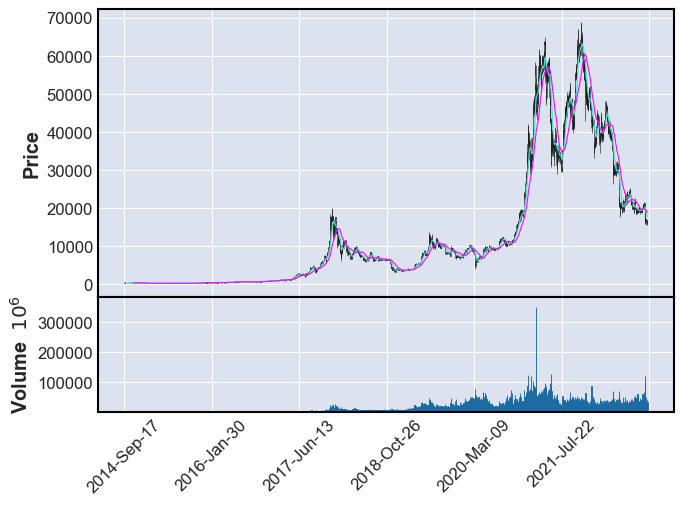

In [495]:
btc = btc.set_index(["Date"])
mpf.plot(btc, type = 'candle', mav=(21,55), volume = True)

[*********************100%***********************]  1 of 1 completed


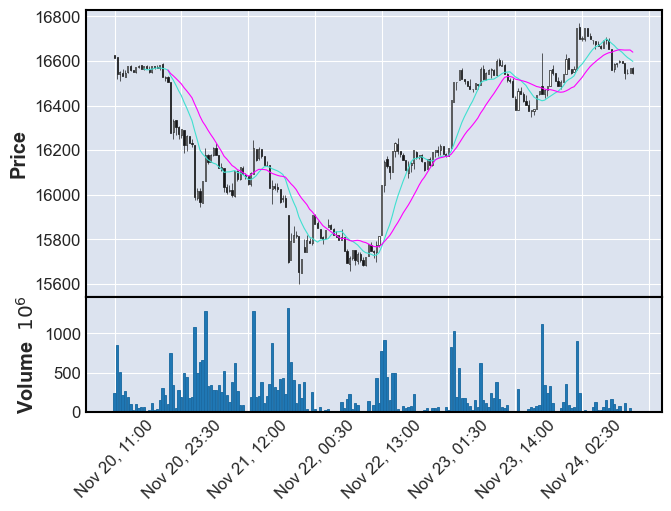

In [ ]:
intraday_btc = yf.download(tickers= 'BTC-USD', period = "5d", interval = "30m")
iday_btc = intraday_btc.loc["2022-11-20 11:00":"2022-11-24 12:00", :]
mpf.plot(iday_btc, type="candle", mav=(12, 21), volume = True)

[*********************100%***********************]  1 of 1 completed


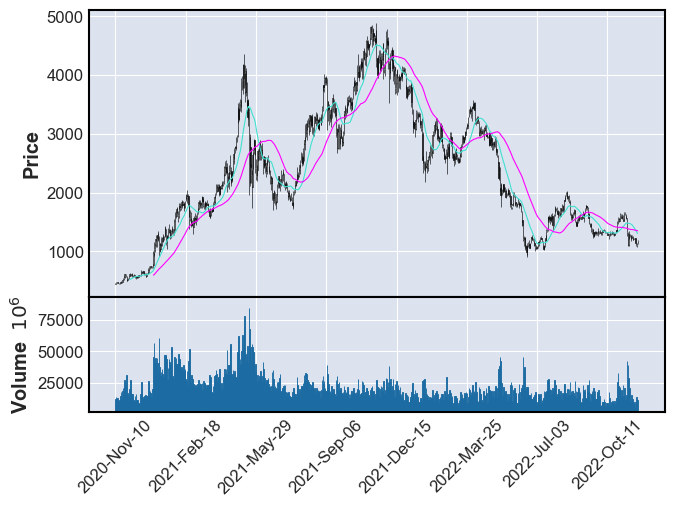

In [ ]:
eth = yf.download('ETH-USD', start = "2020-11-10", end = "2022-11-24")
mpf.plot(eth, type = 'candle', mav=(21,55), volume = True)